Cropping and Rotating

In [1]:
def crop_rotate_dir(input_dir = 'input',output_dir='output', angle = -1.5, left = 135, upper =85, right = 600, lower = 390):
    from PIL import Image
    import os, glob
    # read every image file from the input folder
    for filename in glob.glob(input_dir+'/*.jpg'):
        # print(filename)
        with Image.open(filename) as im:
            # (left, upper, right, lower) = (100, 60, 630, 400)
            rotated = im.rotate(angle, expand = 1)
            im_final = rotated.crop((left, upper, right, lower))            
            im_final.save(filename.replace(input_dir, output_dir))

In [2]:
# Best parameters
crop_rotate_dir(input_dir = 'input',output_dir='output',left = 135, upper =85, right = 600, lower = 390)

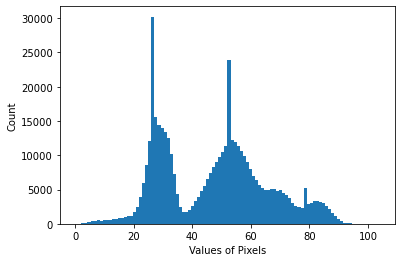

In [3]:
# colmport the necessary libraries
from PIL import Image
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import os, glob

# this is a pipeline that allows you to do an operation on each well for each image
def pipeline(input_dir = 'output'):
    import os, glob
    from PIL import Image
    import numpy as np
    from numpy import asarray
    # read every image file from the input folder
    big_output = []
    pred_outputs = []
    for filename in glob.glob(input_dir+'/*.jpg'):
        img = Image.open(filename).convert('L')
        img_numpydata = asarray(img)
        y = img_numpydata.shape[0] / 16
        x = img_numpydata.shape[1] / 24
        output = np.zeros(shape=(16,24))
        pred_output = np.zeros(shape=(16,24))
        rows = 0
        columns = 0
        for col in np.arange(0, img_numpydata.shape[0], y):
            for row in np.arange(0, img_numpydata.shape[1], x):
                out = img_numpydata[round(col):round(col+y),round(row):round(row+x)]
                std = np.std(out)
                mean = np.mean(out)
                min = np.amin(out)
                output[rows,columns] = min
                pred_output[rows,columns] = 1 if min < mean-4*std else 0
                # pred_output[rows,columns] = 1 if min < 38 else 0
                columns += 1
            rows += 1
            columns = 0
        np.savetxt(filename.replace(input_dir, 'output_values').replace('.jpg','.txt'), output)
        np.savetxt(filename.replace(input_dir, 'output_pred').replace('.jpg','.txt'), pred_output, fmt='%1i')
        pred_outputs.append(pred_output)
        big_output.append(output)
    # plot histogram of output
    plt.xlabel('Values of Pixels')
    plt.ylabel('Count')
    plt.hist(asarray(big_output).flatten(), bins=100)

pipeline()


# Using the new data
This demo below assumes that we have a folder output_pred/ that has a numpy arrays as txt 16x24 as the output of the model for each well. 
It also assumes that we have a data.csv which is the data that Ginko gave us on Oct 27th.

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# takes in a numpy array with the predicted labels and csv and outputs metrics 
def verification(pred_filename, df2):
    # get destination_plate_bcode
    destination_plate_bcode = int(pred_filename.split('_')[-1].split('.')[0])
    # read in csv
    df = df2.copy()
    # get the rows which have matching "destination_plate_bcode"
    df3 = df[df['destination_plate_bcode'] == destination_plate_bcode]
    # read destination well of each row
    destination_wells = df3['destination_well'].values

    letters_to_index = {
        "A": 0,
        "B": 1,
        "C": 2,
        "D": 3,
        "E": 4,
        "F": 5,
        "G": 6,
        "H": 7,
        "I": 8,
        "J": 9,
        "K": 10,
        "L": 11,
        "M": 12,
        "N": 13,
        "O": 14,
        "P": 15
    }

    ground_truth = np.zeros(shape=(16,24))
    for destination in destination_wells:
        row = letters_to_index[destination[0]]
        col = int(destination[1:]) - 1
        ground_truth[row, col] = 1
    # print(pd.DataFrame(ground_truth))
    # read in the predicted values
    pred = np.loadtxt(pred_filename)
    # calculate the metrics
    cm = confusion_matrix(ground_truth.flatten(), pred.flatten())
    tp = np.sum(np.logical_and(pred == 1, ground_truth == 1))
    tn = np.sum(np.logical_and(pred == 0, ground_truth == 0))
    fp = np.sum(np.logical_and(pred == 1, ground_truth == 0))
    fn = np.sum(np.logical_and(pred == 0, ground_truth == 1))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return precision, recall, f1, accuracy, not df3.empty, ground_truth, cm

# get the average accuracy of all the images
def verification_all_plates(dir="output_pred"):
    import os, glob
    # read every image file from the input folder
    acc = []
    precision = []
    recall = []
    f1_scores = []
    ground_truth = []
    cm = np.zeros(shape=(2,2))
    df = pd.read_csv('data.csv')

    for filename in glob.glob(dir+'/*.txt'):
        # print(filename)
        p, r, f1, a, no_ground_truth, g, cmm = verification(filename, df)
        # print(a)
        if no_ground_truth:
            acc.append(a)
            precision.append(p)
            recall.append(r)
            f1_scores.append(f1)
            ground_truth.append(g)
            cm += cmm
    return np.mean(acc), acc, precision, recall, f1_scores, ground_truth, cm

# output = verification_all_plates()
# test
df = pd.read_csv('data.csv')
verification("/Users/JIMENDI1/Documents/ginko/output_pred/220104_150753_862416.txt", df)

(0.9701492537313433,
 0.9090909090909091,
 0.9386281588447654,
 0.9557291666666666,
 True,
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 1., 0.

In [16]:
mean_accuracy, accuracy, precision, recall, f1,ground_truth, confusion_matrix = verification_all_plates()


/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/official/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/opt/anacon

In [38]:
import math # len(output[1])
def Average(lst):
    return sum(lst) / len(lst)

precision = [item for item in precision if not(math.isnan(item)) == True]
print(Average(precision))

recall = [item for item in recall if not(math.isnan(item)) == True]
print(Average(recall))

f1 = [item for item in f1 if not(math.isnan(item)) == True]
print(Average(f1))

0.8689582994200972
0.5875590646823728
0.7405632941163782


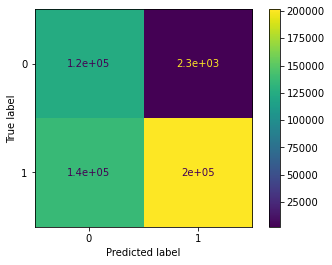

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()

In [28]:
# confusion matrix percentages
(confusion_matrix/confusion_matrix.sum())

array([[0.2681238 , 0.00489007],
       [0.29370527, 0.43328086]])

(array([125.,  27.,  15.,  46.,  27.,  24.,  13.,  25.,  11.,  20.,  14.,
         12.,   9.,  23.,  32.,  20.,  16.,  31., 120., 601.]),
 array([0.        , 0.04908854, 0.09817708, 0.14726563, 0.19635417,
        0.24544271, 0.29453125, 0.34361979, 0.39270833, 0.44179687,
        0.49088542, 0.53997396, 0.5890625 , 0.63815104, 0.68723958,
        0.73632812, 0.78541667, 0.83450521, 0.88359375, 0.93268229,
        0.98177083]),
 <BarContainer object of 20 artists>)

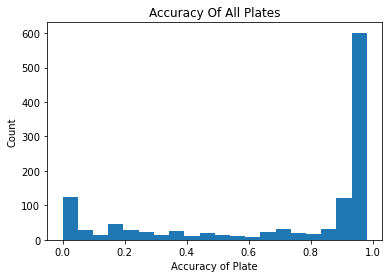

In [7]:
import matplotlib.pyplot as plt
plt.title("Accuracy Of All Plates")
plt.xlabel('Accuracy of Plate')
plt.ylabel('Count')
plt.hist(accuracy, bins=20)

(array([ 81.,   0.,   0.,   2.,   0.,   7.,   5.,   0.,   7.,   0.,  41.,
          7.,   3.,  14.,   2.,   6.,  10.,  24.,  46., 818.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

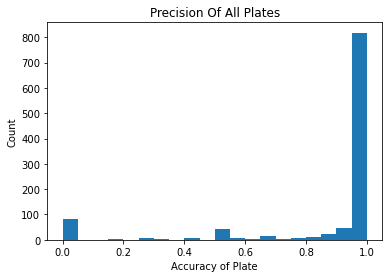

In [8]:
plt.title("Precision Of All Plates")
plt.xlabel('Accuracy of Plate')
plt.ylabel('Count')
plt.hist(precision, bins=20)

(array([417.,   1.,   4.,   0.,   2.,   5.,   4.,   1.,   3.,   5.,   6.,
          4.,  12.,  17.,  14.,  14.,  29.,  59., 312., 302.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

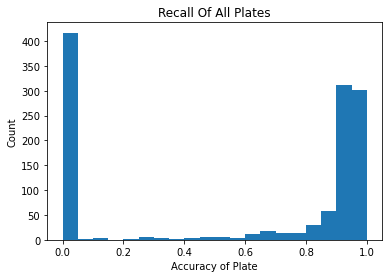

In [9]:
plt.title("Recall Of All Plates")
plt.xlabel('Accuracy of Plate')
plt.ylabel('Count')
plt.hist(recall, bins=20)

(array([197.,   2.,   0.,   0.,   3.,   2.,   2.,   2.,   4.,   6.,   4.,
          5.,   3.,   7.,  12.,  15.,  23.,  27.,  93., 585.]),
 array([0.00519481, 0.05427543, 0.10335606, 0.15243669, 0.20151732,
        0.25059795, 0.29967858, 0.34875921, 0.39783984, 0.44692047,
        0.4960011 , 0.54508173, 0.59416235, 0.64324298, 0.69232361,
        0.74140424, 0.79048487, 0.8395655 , 0.88864613, 0.93772676,
        0.98680739]),
 <BarContainer object of 20 artists>)

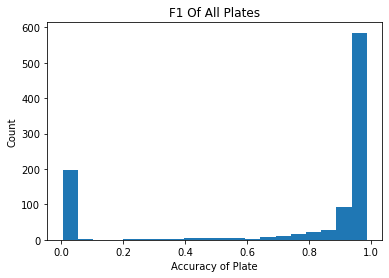

In [10]:
plt.title("F1 Of All Plates")
plt.xlabel('Accuracy of Plate')
plt.ylabel('Count')
plt.hist(f1, bins=20)

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# ROC Function
def plot_roc_curve(Y_test, model_probs):

	random_probs = [0 for _ in range(len(Y_test))]
	# calculate AUC
	model_auc = roc_auc_score(Y_test, model_probs)
	# summarize score
	print('Model: ROC AUC=%.3f' % (model_auc))
	# calculate ROC Curve
		# For the Random Model
	random_fpr, random_tpr, _ = roc_curve(Y_test, random_probs)
		# For the actual model
	model_fpr, model_tpr, _ = roc_curve(Y_test, model_probs)
	# Plot the roc curve for the model and the random model line
	plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
	plt.plot(model_fpr, model_tpr, marker='.', label='Model')
	# Create labels for the axis
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()

Model: ROC AUC=0.789


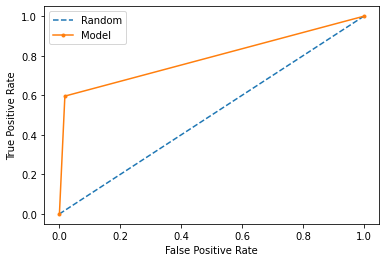

In [12]:
import os, glob
import numpy as np
# import all txt files to numpy array
preds = []
for filename in glob.glob('output_pred'+'/*.txt'):
    pred = np.loadtxt(filename)
    preds.append(pred)

plot_roc_curve(np.array(ground_truth).flatten(), np.array(preds).flatten())


In [13]:
pred = np.loadtxt('output_pred/220104_150753_862416.txt')
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
